# Dengue Case Prediction and Analysis Pipeline

## Phase 1: Data Preprocessing & Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, matthews_corrcoef, accuracy_score, roc_curve, auc
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Dense
from prophet import Prophet
import xgboost as xgb
import warnings

warnings.filterwarnings('ignore')

# Load Data
file_path = 'Dengue.xlsx'
df = pd.read_excel(file_path)

# Display first few rows
print(df.head())
print(df.columns)

e:\last ml with small dataset\.venv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):
e:\last ml with small dataset\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


   Year      Month  Affected  Barishal(Affected)  Chattogram(Affected)  \
0  2019  September     16856                1569                  1336   
1  2019    October      8143                 971                   806   
2  2019   November      4011                 373                   641   
3  2019   December      1247                  55                   179   
4  2020    January       241                   3                     6   

   Dhaka(Affected)  Khulna(Affected)  Mymensingh(Affected)  \
0             9733              3837                   318   
1             3590              2092                   144   
2             2087               767                    77   
3              814               135                    20   
4              171                 5                     7   

   Rajshahi(Affected)  Rangpur(Affected)  Sylhet(Affected)  Barishal(Died)  \
0                 987                289               166               8   
1                 398     

        Date  Dengue_Cases
0 2019-09-01         16856
1 2019-10-01          8143
2 2019-11-01          4011
3 2019-12-01          1247
4 2020-01-01           241


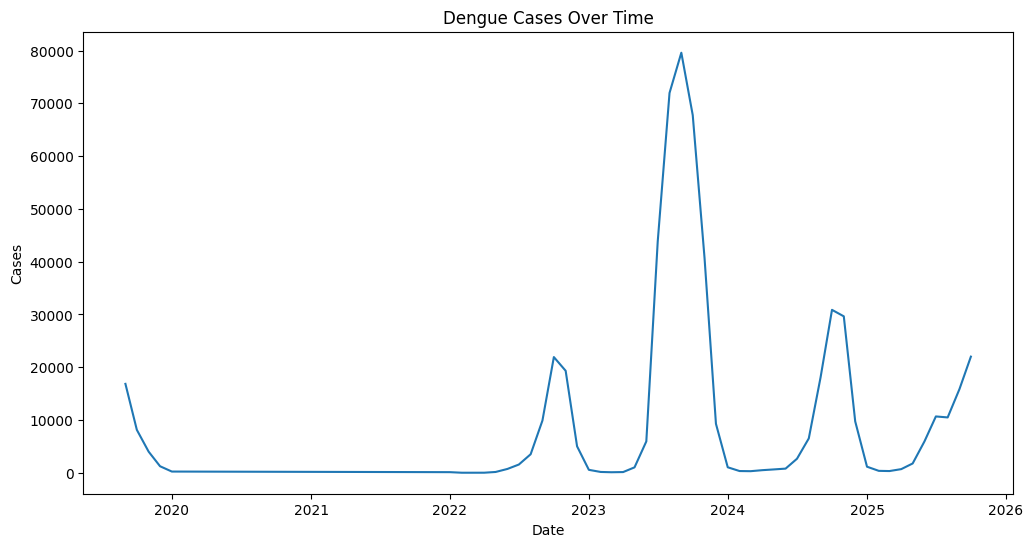

In [2]:
# Data Cleaning
# Create Date column from Year and Month
month_map = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6,
    'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12
}
df['Month_Num'] = df['Month'].map(month_map)
df['Date'] = pd.to_datetime(df[['Year', 'Month_Num']].assign(DAY=1).rename(columns={'Year': 'year', 'Month_Num': 'month', 'DAY': 'day'}))

# Sort by Date
df = df.sort_values('Date').reset_index(drop=True)

# Handle missing values (Forward Fill)
df = df.ffill()

# Select Target Column
target_col = 'Affected' # Total Cases
data = df[['Date', target_col]].copy()
data.columns = ['Date', 'Dengue_Cases']

print(data.head())

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Dengue_Cases'])
plt.title('Dengue Cases Over Time')
plt.xlabel('Date')
plt.ylabel('Cases')
plt.show()

In [3]:
# Normalization
scaler = MinMaxScaler(feature_range=(0, 1))
data['Dengue_Cases_Scaled'] = scaler.fit_transform(data[['Dengue_Cases']])

# Data Splitting
train_size = int(len(data) * 0.70)
val_size = int(len(data) * 0.15)
test_size = len(data) - train_size - val_size

train_data = data.iloc[:train_size]
val_data = data.iloc[train_size:train_size+val_size]
test_data = data.iloc[train_size+val_size:]

print(f"Train Size: {len(train_data)}")
print(f"Validation Size: {len(val_data)}")
print(f"Test Size: {len(test_data)}")

# Sequence Creation
def create_sequences(dataset, look_back=3):
    X, y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), 0])
        y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(y)

look_back = 3

# Prepare data for LSTM/GRU/RNN (requires 3D input: [samples, time steps, features])
# We use the scaled data
train_scaled = train_data['Dengue_Cases_Scaled'].values.reshape(-1, 1)

# For validation, we need the last 'look_back' points from train
val_input = np.concatenate((train_scaled[-look_back:], val_data['Dengue_Cases_Scaled'].values.reshape(-1, 1)))
# For test, we need the last 'look_back' points from val
test_input = np.concatenate((val_data['Dengue_Cases_Scaled'].values.reshape(-1, 1)[-look_back:], test_data['Dengue_Cases_Scaled'].values.reshape(-1, 1)))

X_train, y_train = create_sequences(train_scaled, look_back)
X_val, y_val = create_sequences(val_input, look_back)
X_test, y_test = create_sequences(test_input, look_back)

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")

Train Size: 35
Validation Size: 7
Test Size: 9
X_train shape: (32, 3, 1)
X_val shape: (7, 3, 1)
X_test shape: (9, 3, 1)


## Phase 2: Training Base Learners (Regression)

In [4]:
# Function to build and train models
def build_model(model_type, input_shape):
    model = Sequential()
    if model_type == 'LSTM':
        model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
        model.add(LSTM(50))
    elif model_type == 'GRU':
        model.add(GRU(50, return_sequences=True, input_shape=input_shape))
        model.add(GRU(50))
    elif model_type == 'RNN':
        model.add(SimpleRNN(50, return_sequences=True, input_shape=input_shape))
        model.add(SimpleRNN(50))
    
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Train LSTM
print("Training LSTM...")
lstm_model = build_model('LSTM', (look_back, 1))
lstm_model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)

# Train GRU
print("Training GRU...")
gru_model = build_model('GRU', (look_back, 1))
gru_model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)

# Train RNN
print("Training RNN...")
rnn_model = build_model('RNN', (look_back, 1))
rnn_model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)

# Train Prophet
print("Training Prophet...")
prophet_data = train_data[['Date', 'Dengue_Cases']].rename(columns={'Date': 'ds', 'Dengue_Cases': 'y'})
prophet_model = Prophet()
prophet_model.fit(prophet_data)

print("Base Learners Trained.")

Training LSTM...
Training GRU...
Training RNN...
Training Prophet...


23:13:14 - cmdstanpy - INFO - Chain [1] start processing
23:13:15 - cmdstanpy - INFO - Chain [1] done processing


Base Learners Trained.


## Phase 3: Stacked Ensemble Construction

In [5]:
# Generate Validation Predictions
# LSTM, GRU, RNN
lstm_val_pred = scaler.inverse_transform(lstm_model.predict(X_val))
gru_val_pred = scaler.inverse_transform(gru_model.predict(X_val))
rnn_val_pred = scaler.inverse_transform(rnn_model.predict(X_val))

# Prophet
val_dates = val_data[['Date']].rename(columns={'Date': 'ds'})
prophet_val_pred = prophet_model.predict(val_dates)['yhat'].values.reshape(-1, 1)

# Ensure all have same length
min_len = min(len(lstm_val_pred), len(prophet_val_pred))
lstm_val_pred = lstm_val_pred[:min_len]
gru_val_pred = gru_val_pred[:min_len]
rnn_val_pred = rnn_val_pred[:min_len]
prophet_val_pred = prophet_val_pred[:min_len]
y_val_actual = val_data['Dengue_Cases'].values[:min_len]

# Prepare Meta-Features
meta_X_val = np.column_stack((lstm_val_pred, gru_val_pred, rnn_val_pred, prophet_val_pred))
meta_y_val = y_val_actual

# Train Meta-Model (XGBoost)
print("Training XGBoost Meta-Model...")
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
xgb_model.fit(meta_X_val, meta_y_val)

# Generate Test Predictions
# Base Models
lstm_test_pred = scaler.inverse_transform(lstm_model.predict(X_test))
gru_test_pred = scaler.inverse_transform(gru_model.predict(X_test))
rnn_test_pred = scaler.inverse_transform(rnn_model.predict(X_test))

test_dates = test_data[['Date']].rename(columns={'Date': 'ds'})
prophet_test_pred = prophet_model.predict(test_dates)['yhat'].values.reshape(-1, 1)

# Ensure alignment
min_len_test = min(len(lstm_test_pred), len(prophet_test_pred))
lstm_test_pred = lstm_test_pred[:min_len_test]
gru_test_pred = gru_test_pred[:min_len_test]
rnn_test_pred = rnn_test_pred[:min_len_test]
prophet_test_pred = prophet_test_pred[:min_len_test]
y_test_actual = test_data['Dengue_Cases'].values[:min_len_test]

# Meta Features for Test
meta_X_test = np.column_stack((lstm_test_pred, gru_test_pred, rnn_test_pred, prophet_test_pred))

# Final Ensemble Predictions
ensemble_test_pred = xgb_model.predict(meta_X_test)

print("Ensemble Predictions Generated.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
Training XGBoost Meta-Model...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
Ensemble Predictions Generated.


## Phase 4 & 5: Classification Transformation & Evaluation

In [6]:
# Define Threshold
threshold = np.percentile(df['Affected'], 75)
print(f"Outbreak Threshold (75th Percentile): {threshold}")

def get_class(value, threshold):
    return 1 if value > threshold else 0

# Binarize Actuals
y_test_class = [get_class(y, threshold) for y in y_test_actual]

# Binarize Predictions
models_preds = {
    'LSTM': lstm_test_pred,
    'GRU': gru_test_pred,
    'RNN': rnn_test_pred,
    'Prophet': prophet_test_pred,
    'Ensemble': ensemble_test_pred
}

metrics_list = []

for name, preds in models_preds.items():
    # Flatten preds
    preds_flat = preds.flatten() if hasattr(preds, 'flatten') else preds
    
    # Binarize
    preds_class = [get_class(p, threshold) for p in preds_flat]
    
    # Metrics
    acc = accuracy_score(y_test_class, preds_class)
    prec_macro = precision_score(y_test_class, preds_class, average='macro')
    rec_macro = recall_score(y_test_class, preds_class, average='macro')
    f1_macro = f1_score(y_test_class, preds_class, average='macro')
    
    prec_micro = precision_score(y_test_class, preds_class, average='micro')
    rec_micro = recall_score(y_test_class, preds_class, average='micro')
    f1_micro = f1_score(y_test_class, preds_class, average='micro')
    
    mcc = matthews_corrcoef(y_test_class, preds_class)
    
    # AUC (using raw predictions as scores)
    # Normalize scores to 0-1 for AUC if needed, but roc_auc_score handles raw scores.
    # However, we need to handle the case where only one class is present in y_test_class
    try:
        fpr, tpr, _ = roc_curve(y_test_class, preds_flat)
        auc_score = auc(fpr, tpr)
    except:
        auc_score = 0
        
    metrics_list.append({
        'Method': name,
        'Macro Prec': prec_macro, 'Macro Rec': rec_macro, 'Macro F1': f1_macro,
        'Micro Prec': prec_micro, 'Micro Rec': rec_micro, 'Micro F1': f1_micro,
        'MCC': mcc, 'Accuracy': acc, 'AUC': auc_score
    })

metrics_df = pd.DataFrame(metrics_list)
print(metrics_df)

# Highlight best values (Visual inspection in notebook)
# In a real report, we would bold them. Here we just print the table.

Outbreak Threshold (75th Percentile): 13275.0
     Method  Macro Prec  Macro Rec  Macro F1  Micro Prec  Micro Rec  Micro F1  \
0      LSTM    0.388889   0.500000  0.437500    0.777778   0.777778  0.777778   
1       GRU    0.833333   0.928571  0.861538    0.888889   0.888889  0.888889   
2       RNN    0.678571   0.678571  0.678571    0.777778   0.777778  0.777778   
3   Prophet    0.642857   0.642857  0.444444    0.444444   0.444444  0.444444   
4  Ensemble    0.833333   0.928571  0.861538    0.888889   0.888889  0.888889   

        MCC  Accuracy       AUC  
0  0.000000  0.777778  1.000000  
1  0.755929  0.888889  0.928571  
2  0.357143  0.777778  0.857143  
3  0.285714  0.444444  0.928571  
4  0.755929  0.888889  0.892857  


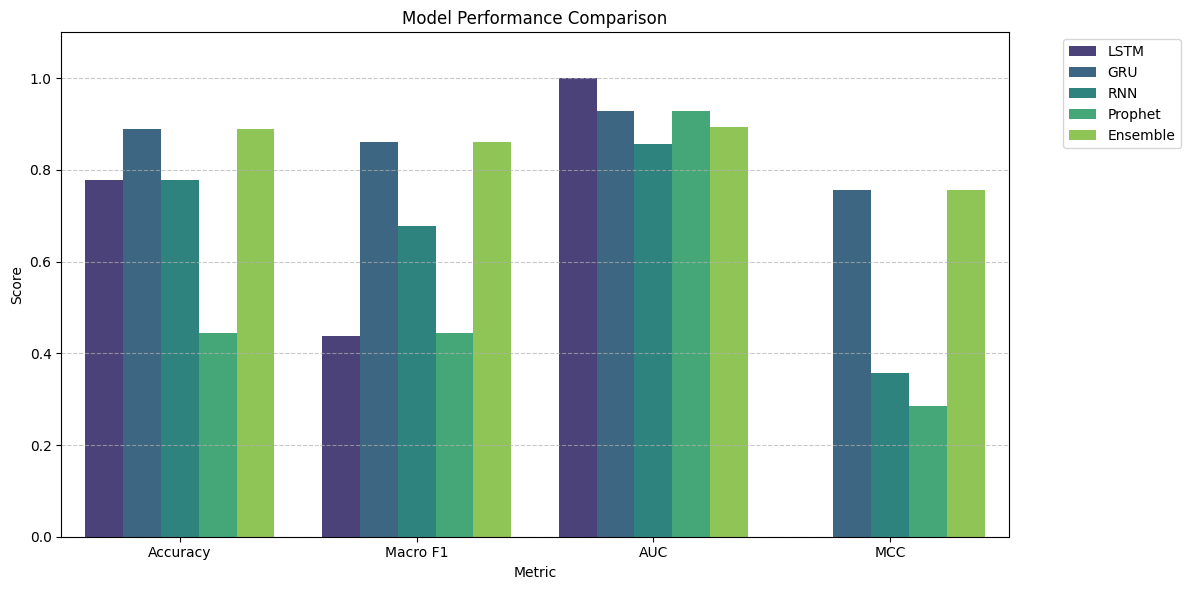

In [12]:
# Model Comparison Graph
plt.figure(figsize=(12, 6))
metrics_to_plot = ['Accuracy', 'Macro F1', 'AUC', 'MCC']
metrics_melted = metrics_df.melt(id_vars='Method', value_vars=metrics_to_plot, var_name='Metric', value_name='Score')

sns.barplot(x='Metric', y='Score', hue='Method', data=metrics_melted, palette='viridis')
plt.title('Model Performance Comparison')
plt.ylim(0, 1.1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Phase 6: Spatial Analysis

     District   Cases      Lat      Lon
0    Barishal   70229  22.7010  90.3535
1  Chattogram   82052  22.3569  91.7832
2       Dhaka  318370  23.8103  90.4125
3      Khulna   72059  22.8456  89.5403
4  Mymensingh   15415  24.7471  90.4203
5    Rajshahi   31171  24.3636  88.6241
6     Rangpur    8504  25.7439  89.2752
7      Sylhet    9484  24.8949  91.8687
Moran's I: -0.197233210372452


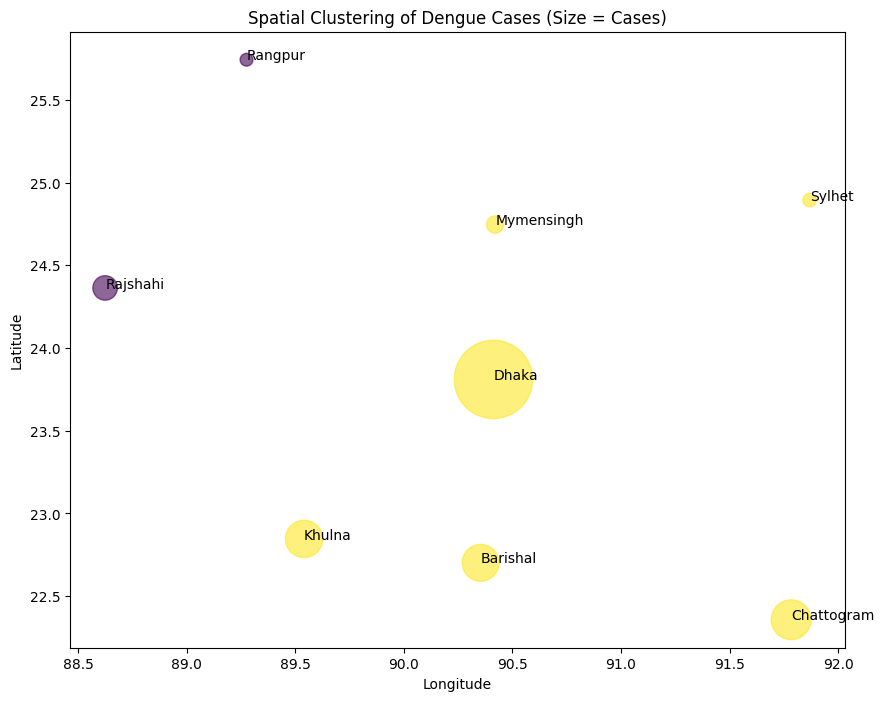

In [14]:
from sklearn.cluster import DBSCAN

# Coordinates for Divisions (Approximate)
division_coords = {
    'Barishal': (22.7010, 90.3535),
    'Chattogram': (22.3569, 91.7832),
    'Dhaka': (23.8103, 90.4125),
    'Khulna': (22.8456, 89.5403),
    'Mymensingh': (24.7471, 90.4203),
    'Rajshahi': (24.3636, 88.6241),
    'Rangpur': (25.7439, 89.2752),
    'Sylhet': (24.8949, 91.8687)
}

# Aggregate cases by district (Total over the period)
district_cols = [col for col in df.columns if '(Affected)' in col]
district_totals = df[district_cols].sum()
district_names = [col.replace('(Affected)', '') for col in district_cols]

spatial_data = pd.DataFrame({
    'District': district_names,
    'Cases': district_totals.values,
    'Lat': [division_coords[d][0] for d in district_names],
    'Lon': [division_coords[d][1] for d in district_names]
})

print(spatial_data)

# DBSCAN Clustering
# We cluster based on location. Weighting by cases is tricky in standard DBSCAN.
# Usually, we look for spatial clusters of high cases.
# Here we just cluster the locations and maybe visualize intensity.
coords = spatial_data[['Lat', 'Lon']].values
db = DBSCAN(eps=1.5, min_samples=2).fit(coords)
spatial_data['Cluster'] = db.labels_

# Moran's I Calculation
def calculate_morans_i(values, coords):
    N = len(values)
    w = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            if i != j:
                dist = np.linalg.norm(coords[i] - coords[j])
                w[i][j] = 1 / (dist + 1e-6) # Inverse distance weight
    
    W = np.sum(w)
    mean_val = np.mean(values)
    
    num = 0
    den = 0
    for i in range(N):
        den += (values[i] - mean_val)**2
        for j in range(N):
            num += w[i][j] * (values[i] - mean_val) * (values[j] - mean_val)
            
    return (N / W) * (num / den)

moran_i = calculate_morans_i(spatial_data['Cases'].values, coords)
print(f"Moran's I: {moran_i}")

# Visuals (Scatter Plot)
plt.figure(figsize=(10, 8))
plt.scatter(spatial_data['Lon'], spatial_data['Lat'], s=spatial_data['Cases']/100, c=spatial_data['Cluster'], cmap='viridis', alpha=0.6)
for i, txt in enumerate(spatial_data['District']):
    plt.annotate(txt, (spatial_data['Lon'][i], spatial_data['Lat'][i]))
plt.title('Spatial Clustering of Dengue Cases (Size = Cases)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

## Phase 7: Future Prediction (Forecasting)

In [15]:
# Retrain on Full Dataset
full_scaled = data['Dengue_Cases_Scaled'].values.reshape(-1, 1)
X_full, y_full = create_sequences(full_scaled, look_back)
X_full = np.reshape(X_full, (X_full.shape[0], X_full.shape[1], 1))

# Retrain Base Models
lstm_full = build_model('LSTM', (look_back, 1))
lstm_full.fit(X_full, y_full, epochs=50, batch_size=16, verbose=0)

gru_full = build_model('GRU', (look_back, 1))
gru_full.fit(X_full, y_full, epochs=50, batch_size=16, verbose=0)

rnn_full = build_model('RNN', (look_back, 1))
rnn_full.fit(X_full, y_full, epochs=50, batch_size=16, verbose=0)

prophet_full = Prophet()
prophet_full.fit(data[['Date', 'Dengue_Cases']].rename(columns={'Date': 'ds', 'Dengue_Cases': 'y'}))

# Generate Meta Features for Full Data
lstm_full_pred = scaler.inverse_transform(lstm_full.predict(X_full))
gru_full_pred = scaler.inverse_transform(gru_full.predict(X_full))
rnn_full_pred = scaler.inverse_transform(rnn_full.predict(X_full))

# Prophet Predictions for Full Data
prophet_full_pred = prophet_full.predict(data[['Date']].rename(columns={'Date': 'ds'}).iloc[look_back:])['yhat'].values.reshape(-1, 1)

# Align
min_len_full = min(len(lstm_full_pred), len(prophet_full_pred))
lstm_full_pred = lstm_full_pred[:min_len_full]
gru_full_pred = gru_full_pred[:min_len_full]
rnn_full_pred = rnn_full_pred[:min_len_full]
prophet_full_pred = prophet_full_pred[:min_len_full]
y_full_actual = data['Dengue_Cases'].values[look_back:][:min_len_full]

meta_X_full = np.column_stack((lstm_full_pred, gru_full_pred, rnn_full_pred, prophet_full_pred))
meta_y_full = y_full_actual

# Retrain XGBoost
xgb_full = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
xgb_full.fit(meta_X_full, meta_y_full)

# Recursive Forecasting for Next 6 Months
future_months = 6
last_sequence = full_scaled[-look_back:]
future_predictions = []
future_dates = pd.date_range(start=data['Date'].iloc[-1], periods=future_months+1, freq='M')[1:]

current_seq = last_sequence.reshape(1, look_back, 1)

for i in range(future_months):
    # Base Predictions
    p_lstm = scaler.inverse_transform(lstm_full.predict(current_seq))[0][0]
    p_gru = scaler.inverse_transform(gru_full.predict(current_seq))[0][0]
    p_rnn = scaler.inverse_transform(rnn_full.predict(current_seq))[0][0]
    
    # Prophet Prediction
    next_date = future_dates[i]
    p_prophet = prophet_full.predict(pd.DataFrame({'ds': [next_date]}))['yhat'].values[0]
    
    # Ensemble Prediction
    meta_input = np.array([[p_lstm, p_gru, p_rnn, p_prophet]])
    final_pred = xgb_full.predict(meta_input)[0]
    
    future_predictions.append(final_pred)
    
    # Update Sequence
    # We need to scale the final_pred back to feed into the model
    final_pred_scaled = scaler.transform([[final_pred]])[0][0]
    current_seq = np.append(current_seq[:, 1:, :], [[[final_pred_scaled]]], axis=1)

print("Future Predictions:", future_predictions)

# Classify Future Risk
future_risk = ['High' if p > threshold else 'Low' for p in future_predictions] # Simplified threshold
print("Future Risk Levels:", future_risk)

23:19:51 - cmdstanpy - INFO - Chain [1] start processing
23:19:51 - cmdstanpy - INFO - Chain [1] done processing


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 252ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 377ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Future Predictions: [np.float32(5780.605), np.float32(1140.3782), np.float32(169.02254), np.float32(1877.2838), np.float32(5748.618), np.float32(8270.936)]
Future Risk Levels: ['Low', 'Low', 'Low', '

## Phase 8: Blood Reserve Planning by Area

In [16]:
# Constants
SEVERITY_RATE = 0.20 # 20% of cases are severe
UNITS_PER_PATIENT = 2
SAFETY_BUFFER = 50 # Units

# Calculate National Demand
national_demand = []
for pred in future_predictions:
    demand = (pred * SEVERITY_RATE * UNITS_PER_PATIENT) + SAFETY_BUFFER
    national_demand.append(demand)

print("National Blood Demand (Next 6 Months):", national_demand)

# District Shares
total_cases_all = district_totals.sum()
district_shares = district_totals / total_cases_all
district_shares.index = district_names # Fix index to match district names

# Allocation
allocation_df = pd.DataFrame(index=district_names)
for i, month_demand in enumerate(national_demand):
    allocation_df[f'Month_{i+1}'] = district_shares * month_demand

# Hotspot Adjustment (+10% for hotspots)
# We use the clusters found in Phase 6
hotspots = spatial_data[spatial_data['Cluster'] != -1]['District'].tolist()
print("Identified Hotspots:", hotspots)

for district in hotspots:
    if district in allocation_df.index:
        allocation_df.loc[district] *= 1.10

print("Blood Allocation Plan (Units):")
print(allocation_df)

National Blood Demand (Next 6 Months): [np.float32(2362.242), np.float32(506.15128), np.float32(117.60902), np.float32(800.9135), np.float32(2349.4473), np.float32(3358.3743)]
Identified Hotspots: ['Barishal', 'Chattogram', 'Dhaka', 'Khulna', 'Mymensingh', 'Sylhet']
Blood Allocation Plan (Units):
                Month_1     Month_2    Month_3     Month_4      Month_5  \
Barishal     300.498084   64.386922  14.960908  101.883288   298.870488   
Chattogram   351.086713   75.226413  17.479566  119.035264   349.185112   
Dhaka       1362.251705  291.886036  67.822470  461.868778  1354.873302   
Khulna       308.328346   66.064692  15.350753  104.538123   306.658339   
Mymensingh    65.958193   14.132686   3.283863   22.362997    65.600942   
Rajshahi     121.250426   25.980005   6.036699   41.109720   120.593694   
Rangpur       33.079260    7.087805   1.646918   11.215459    32.900092   
Sylhet        40.580442    8.695063   2.020380   13.758719    40.360645   

                Month_6  


## Phase 9: Final Plots for Paper

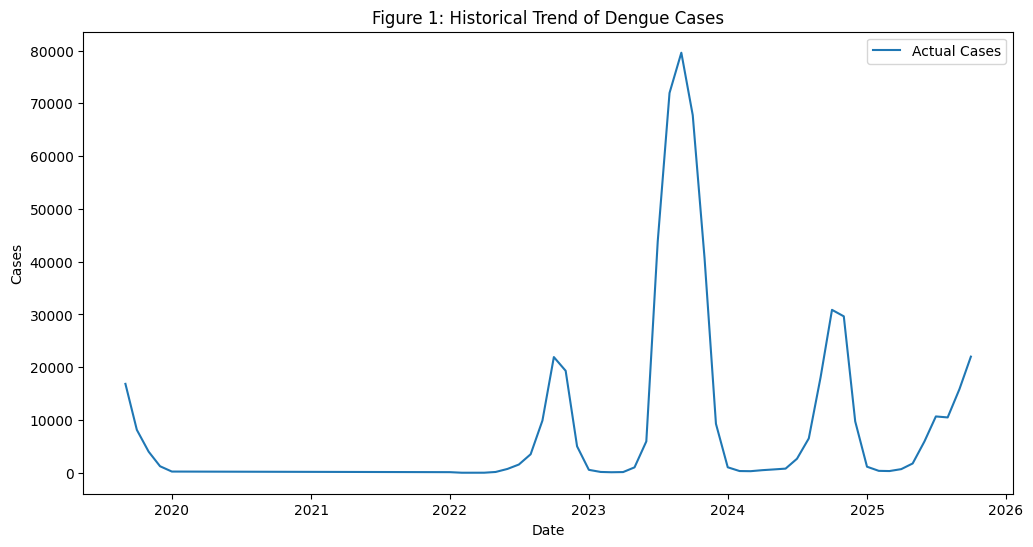

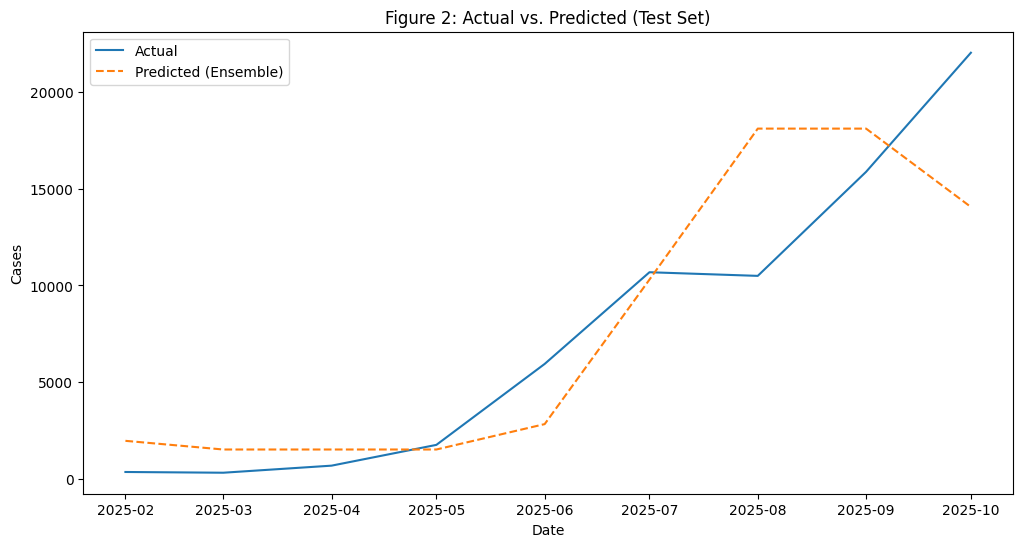

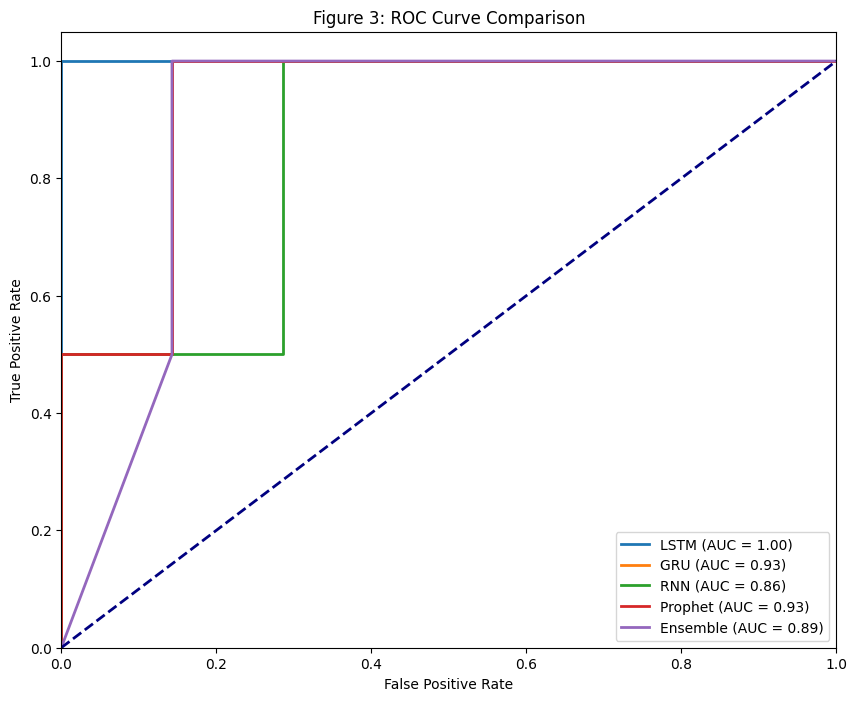

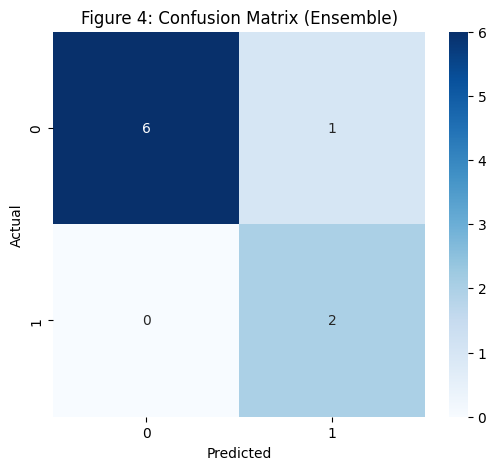

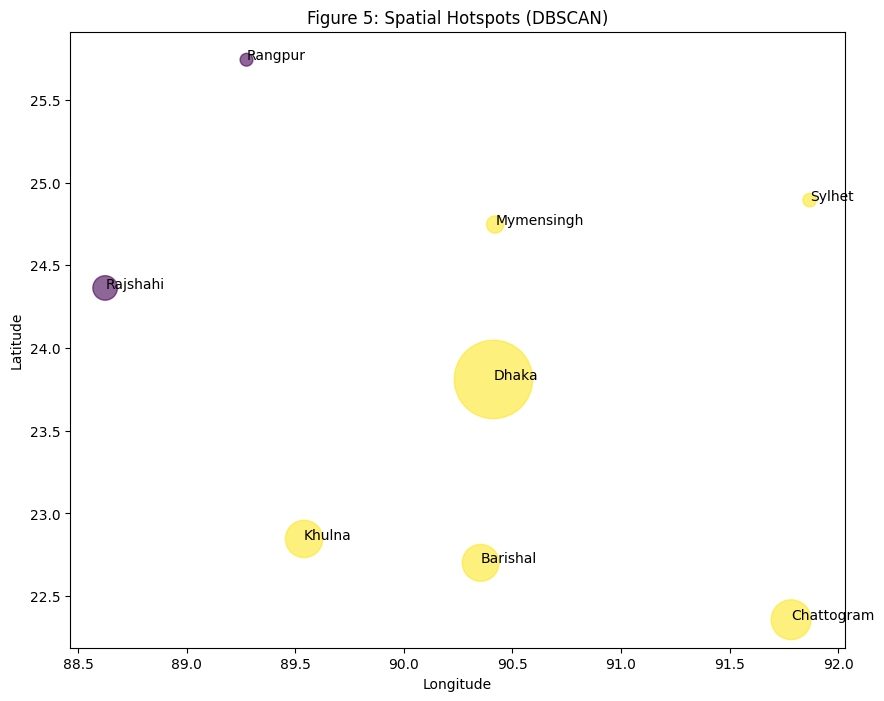

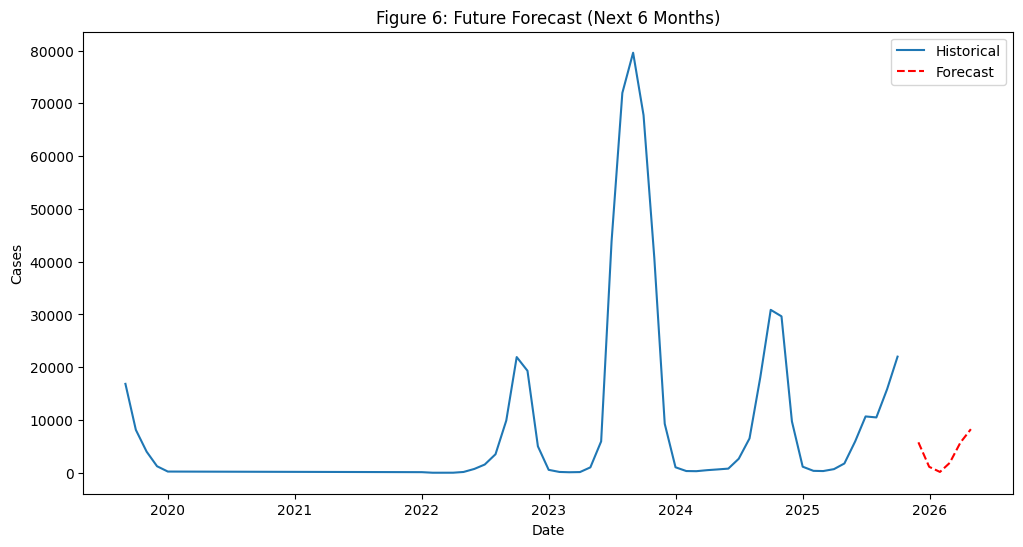

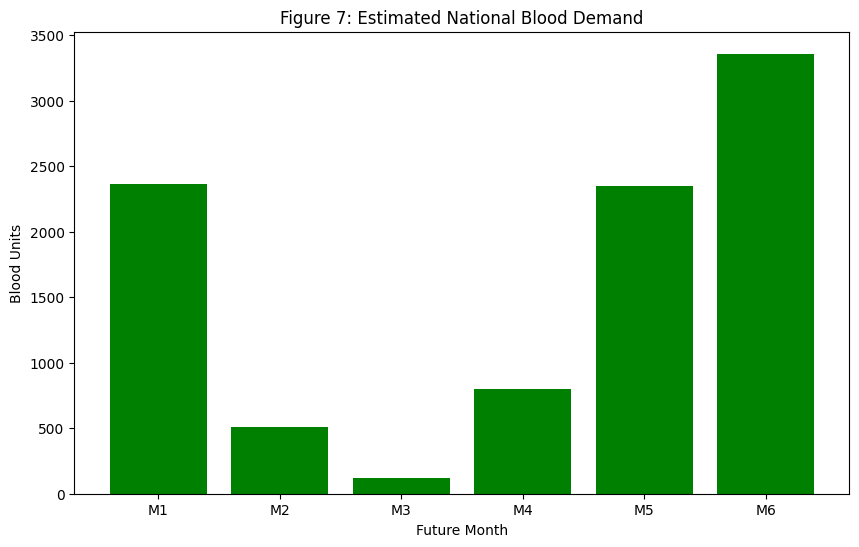

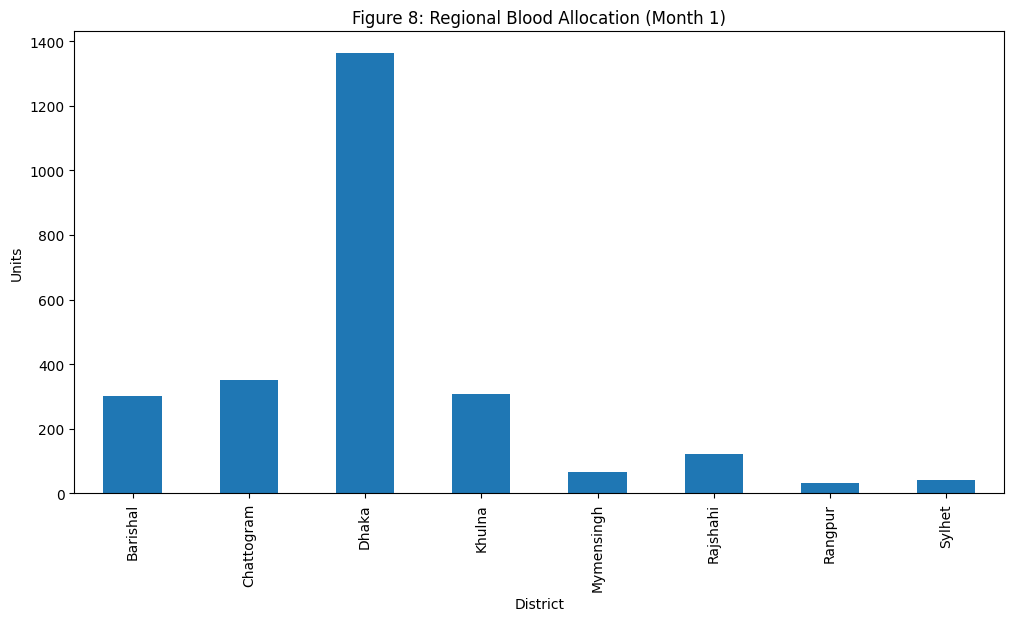

In [18]:
# Figure 1: Historical Trend
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Dengue_Cases'], label='Actual Cases')
plt.title('Figure 1: Historical Trend of Dengue Cases')
plt.xlabel('Date')
plt.ylabel('Cases')
plt.legend()
plt.show()

# Figure 2: Actual vs. Predicted (Test Set)
plt.figure(figsize=(12, 6))
plt.plot(test_data['Date'], y_test_actual, label='Actual')
plt.plot(test_data['Date'], ensemble_test_pred, label='Predicted (Ensemble)', linestyle='--')
plt.title('Figure 2: Actual vs. Predicted (Test Set)')
plt.xlabel('Date')
plt.ylabel('Cases')
plt.legend()
plt.show()

# Figure 3: ROC Curve for All Models
plt.figure(figsize=(10, 8))
for name, preds in models_preds.items():
    # Flatten preds if necessary
    preds_flat = preds.flatten() if hasattr(preds, 'flatten') else preds
    
    # Calculate ROC and AUC
    try:
        fpr, tpr, _ = roc_curve(y_test_class, preds_flat)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')
    except Exception as e:
        print(f"Could not plot ROC for {name}: {e}")

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Figure 3: ROC Curve Comparison')
plt.legend(loc="lower right")
plt.show()

# Figure 4: Confusion Matrix
cm = confusion_matrix(y_test_class, [get_class(p, threshold) for p in ensemble_test_pred])
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Figure 4: Confusion Matrix (Ensemble)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Figure 5: Spatial Hotspots (Already plotted in Phase 6, repeating for completeness)
plt.figure(figsize=(10, 8))
plt.scatter(spatial_data['Lon'], spatial_data['Lat'], s=spatial_data['Cases']/100, c=spatial_data['Cluster'], cmap='viridis', alpha=0.6)
for i, txt in enumerate(spatial_data['District']):
    plt.annotate(txt, (spatial_data['Lon'][i], spatial_data['Lat'][i]))
plt.title('Figure 5: Spatial Hotspots (DBSCAN)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# Figure 6: Future Forecast
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Dengue_Cases'], label='Historical')
plt.plot(future_dates, future_predictions, label='Forecast', linestyle='--', color='red')
plt.title('Figure 6: Future Forecast (Next 6 Months)')
plt.xlabel('Date')
plt.ylabel('Cases')
plt.legend()
plt.show()

# Figure 7: Blood Demand Bar Chart
plt.figure(figsize=(10, 6))
colors = ['red' if r == 'High' else 'green' for r in future_risk]
plt.bar(range(1, 7), national_demand, color=colors)
plt.title('Figure 7: Estimated National Blood Demand')
plt.xlabel('Future Month')
plt.ylabel('Blood Units')
plt.xticks(range(1, 7), [f'M{i}' for i in range(1, 7)])
plt.show()

# Figure 8: Regional Allocation (Month 1)
plt.figure(figsize=(12, 6))
allocation_df['Month_1'].plot(kind='bar')
plt.title('Figure 8: Regional Blood Allocation (Month 1)')
plt.ylabel('Units')
plt.xlabel('District')
plt.show()